# LMP Pricing

#### The Goal of this notebook is to learn about locational marginal pricing, congestion, and losses.

General steps will be:

1) Generate supply and demand side bids
2) Calculate LMP's from these bids
3) Explore Congestion

This notebook is mainly to be used as a heuristic tool in learning about LMP's and CAISO market operations. I'm sure anyone can use ChatGPT to generate a pricing algorithm in seconds, but that teaches us nothing .

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt
import random

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


## What are Locational Marginal Prices? (LMP's)

They are the cost of serving one additional MW of demand at a specific node (location) on the grid, in a specific hour/interval.

Node's are a bus (connection point) in the transmission grid where injections/withdrawals happen. LMPs are node-specific because the cost to serve “one more MW” depends on where it’s needed in the network.


The Locational Marginal Price (LMP) at node \(i\) is

$$
\mathrm{LMP}_i = \text{Marginal Energy Cost} + \text{Marginal Congestion Cost} + \text{Marginal Loss Cost}
$$

**Where**: 

- Energy cost (λ): the base system marginal cost (what the last MW would cost in an unconstrained system).

- Congestion component: extra cost if transmission lines are binding.

- Loss component: extra cost due to marginal line losses.

**Compact form**:

$$
\pi_i = \lambda + \text{Congestion}_i + \text{Losses}_i
$$

**Special case (no congestion, no losses)**:

$$
\pi_i = \lambda \quad \forall i
$$



First, I want to simulate both supply and demand side bids to simulate $\lambda$.

Bids are generally submitted by generators and buyers (typically load serving entities AKA LSE's) who mainly participate in the wholesale market. 

They submit day-ahead bids to procure to provide energy.

In [69]:
# both functions sort by merit order (supply) and willingness to pay (demand)

def generate_supply_bids(n_bids=5, price_range=(10, 50), quantity_range=(10, 100)):
    """
    Generate a DataFrame of supply offers (price $/MWh, quantity MW).
    Sorted ascending by price (merit order).
    """
    bids = [(random.randint(*price_range), random.randint(*quantity_range)) for _ in range(n_bids)]
    bids = sorted(bids, key=lambda x: x[0])
    return pd.DataFrame(bids, columns=['Price ($/MWh)', 'Quantity (MW)'])


def generate_demand_bids(n_bids=5, price_range=(30, 100), quantity_range=(10, 100)):
    """
    Generate a DataFrame of demand bids (price $/MWh, quantity MW).
    Sorted descending by price (highest willingness to pay first).
    """
    bids = [(random.randint(*price_range), random.randint(*quantity_range)) for _ in range(n_bids)]
    bids = sorted(bids, key=lambda x: -x[0])
    return pd.DataFrame(bids, columns=['Price ($/MWh)', 'Quantity (MW)'])


def generate_vertical_demand(quantity=1000, bid_price=1000):
    """
    Generate a vertical demand curve (perfectly inelastic).
    
    Parameters
    ----------
    quantity : int
        The fixed demand in MW.
    bid_price : int
        The (very high) willingness-to-pay price ($/MWh).
    
    Returns
    -------
    pd.DataFrame
        A DataFrame representing a vertical demand curve.
    """
    bids = [(bid_price, quantity)]
    return pd.DataFrame(bids, columns=['Price ($/MWh)', 'Quantity (MW)'])



#### These are very simple bids with no congestion, costs, or line losses in play


The main purposes is to learn.

Let's graph them.

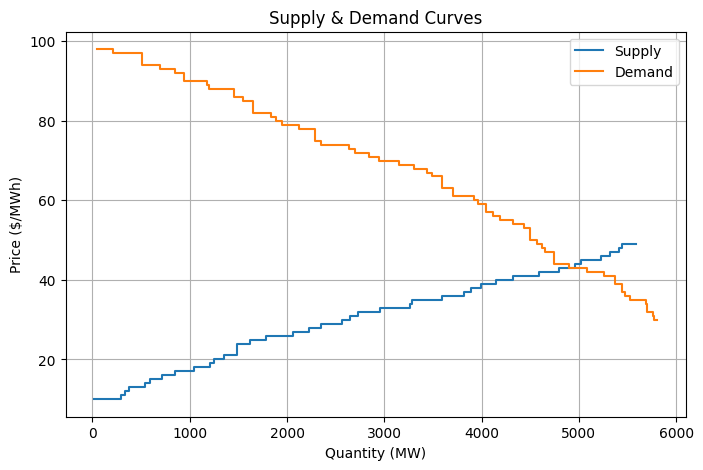

In [70]:
supply = generate_supply_bids(100)
demand = generate_demand_bids(100)

# Compute cumulative MW to represent aggregated demand and supply
supply["CumQty"] = supply["Quantity (MW)"].cumsum()
demand["CumQty"] = demand["Quantity (MW)"].cumsum()

# Plot
plt.figure(figsize=(8,5))
plt.step(supply["CumQty"], supply["Price ($/MWh)"], where="post", label="Supply")
plt.step(demand["CumQty"], demand["Price ($/MWh)"], where="post", label="Demand")

plt.xlabel("Quantity (MW)")
plt.ylabel("Price ($/MWh)")
plt.title("Supply & Demand Curves")
plt.legend()
plt.grid(True)
plt.show()

For illustrative and heuristic purposes, I choose to graph step-wise demand and supply curves.

- The intersect of the supply and demand curves is the market clearing price.

- For demand, bid prices that are higher than the LMP clear, while prices that are below the LMP clear for supply.

- The marginal bid that reaches the clearing price *partially* clears.


In the actual wholesale market, demand can be vertical.
* Load serving entities are relatively inelastic in response to market prices since they *must* serve a base-level of load.

* The clearing price is incredibly low since other factors aren't in play



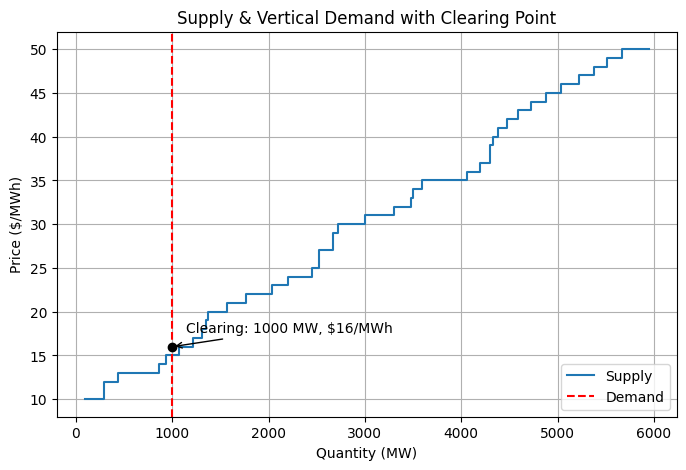

In [71]:
supply = generate_supply_bids(100)
demand = generate_vertical_demand(1000)

# Compute cumulative MW for supply
supply["CumQty"] = supply["Quantity (MW)"].cumsum()
demand_qty = demand["Quantity (MW)"].iloc[0]

# Find clearing point
idx = (supply["CumQty"] >= demand_qty).idxmax()
clearing_price = supply.loc[idx, "Price ($/MWh)"]

# Plot
plt.figure(figsize=(8,5))

# Supply stack
plt.step(supply["CumQty"], supply["Price ($/MWh)"], where="post", label="Supply")

# Vertical demand
plt.axvline(x=demand_qty, color="red", linestyle="--", label="Demand")

# Clearing point
plt.scatter([demand_qty], [clearing_price], color="black", zorder=5)
plt.annotate(f"Clearing: {demand_qty} MW, ${clearing_price:.0f}/MWh",
             xy=(demand_qty, clearing_price),
             xytext=(10,10), textcoords="offset points",
             arrowprops=dict(arrowstyle="->"))

plt.xlabel("Quantity (MW)")
plt.ylabel("Price ($/MWh)")
plt.title("Supply & Vertical Demand with Clearing Point")
plt.legend()
plt.grid(True)
plt.show()


## Congestion

**What is it?**

Electricity must physically flow across the transmission grid and each transmission line has a thermal (ampacity) limit or stability limit.

When demand + generation patterns would overload a line, the system is said to be congested.

#### Potential Congestion Scenarios

1) **Geographic imbalance between cheap supply and load**
    - *Example* : A region has lots of cheap solar or wind but limited transmission out.  On a sunny/windy day, local generation exceeds what the line can carry → the line binds.

    - *Result* : Low/negative LMPs on the “supply-rich” side (too much gen, can’t export).

2) **Peak demand periods**

    - *Example* : During hot afternoons, urban demand spikes. If the lines feeding the city are at capacity, the ISO must turn on expensive local gas peakers.

    - *Result* : congestion cost in city nodes → higher LMPs inside the city than outside.


**Quick Summary**


Most congestion boils down to either too much demand pulling power in (load pockets) or too much generation trying to push power out (export constraints), with regional transfer paths and interties being the classic chokepoints.

When a line is uncongested, cheap generation can flow freely -> system clears at low price.
When it’s congested, demand has to be covered by costlier local units, so prices diverge across the line.